In [20]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from datetime import timedelta
from json import load, dump

from torchmetrics import MeanSquaredError, MeanAbsolutePercentageError

from config import *
from data.util import crop_q_between
from data.compress import decompress
from stages import compress_data, preprocess_data

%reload_ext autoreload
%autoreload 2

In [2]:
with open('results/results_we_norm_all.json', 'r') as file:
    data = load(file)

In [3]:
data = [data['40'][key] for key in data['40'].keys()]

In [4]:
print(len(data))
print(data[0].keys())
print(data[0]['resid'].keys())
print(len(data[0]['resid']['y']))

356
dict_keys(['resid', 'trend', 'overall'])
dict_keys(['y', 'pred'])
108


In [5]:
for section in data:
    for key, series in section.items():
        section[key]['y'] = torch.tensor(series['y'])
        section[key]['pred'] = torch.tensor(series['pred'])

In [6]:
mse = MeanSquaredError().to(CONFIG.device)
def calculate_mse(sec: dict):
    losses = []
    for series in sec.values():
        y = series['y']
        pred = series['pred']
        losses.append(mse(y, pred).item())
    return losses

losses = [calculate_mse(sec) for sec in data]

In [7]:
from pprint import pprint
pprint([(i, loss) for i, loss in enumerate(losses) if int(loss[1]) == 2])

[(35, [16.50344467163086, 2.297379970550537, 18.104454040527344]),
 (36, [24.69901466369629, 2.6290597915649414, 26.03934669494629]),
 (62, [625.6194458007812, 2.1249377727508545, 629.2147216796875]),
 (74, [26.893295288085938, 2.3075075149536133, 30.03296661376953]),
 (160, [5456.59619140625, 2.949104070663452, 5496.05419921875]),
 (210, [15.352936744689941, 2.602423667907715, 13.524882316589355]),
 (214, [71.44918823242188, 2.334094524383545, 75.00318908691406]),
 (227, [7.9363484382629395, 2.15962815284729, 7.81218147277832]),
 (228, [16.373062133789062, 2.6985292434692383, 16.99108123779297]),
 (238, [115.5079574584961, 2.7694921493530273, 114.97577667236328]),
 (260, [372.1863708496094, 2.649186372756958, 385.7034912109375]),
 (298, [69.41831970214844, 2.698509454727173, 73.45423889160156]),
 (308, [20.26486587524414, 2.439030408859253, 23.453060150146484]),
 (313, [40.085636138916016, 2.4996089935302734, 39.613380432128906]),
 (314, [484.1061096191406, 2.440040111541748, 492.7617

In [8]:
losses = torch.tensor(losses)

In [9]:
losses.mean(dim=0)

tensor([584.6528, 126.2024, 627.2394])

In [10]:
worst_trend = losses.max(dim=0)[1]
print(worst_trend, losses[worst_trend])

tensor([131, 344, 131]) tensor([[5.9839e+04, 1.0726e+01, 5.9688e+04],
        [1.4125e+04, 2.0632e+04, 2.0664e+04],
        [5.9839e+04, 1.0726e+01, 5.9688e+04]])


In [11]:
losses.shape

torch.Size([356, 3])

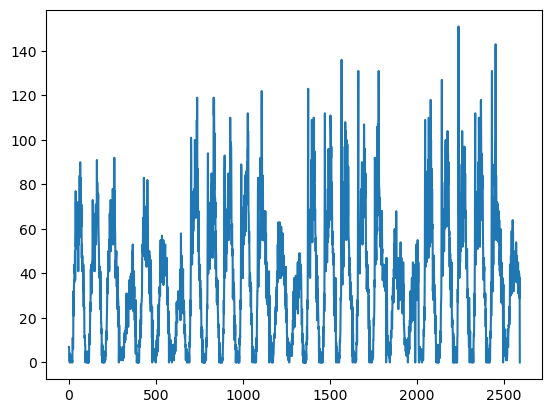

In [12]:
mat_q = CONFIG.load('mat_q.pt')
mat_q = mat_q[:, 10][:, None]
mat_q = crop_q_between(mat_q, CONFIG.read_period, CONFIG.train_period)
plt.plot(mat_q.cpu())

tensor([], dtype=torch.int64)


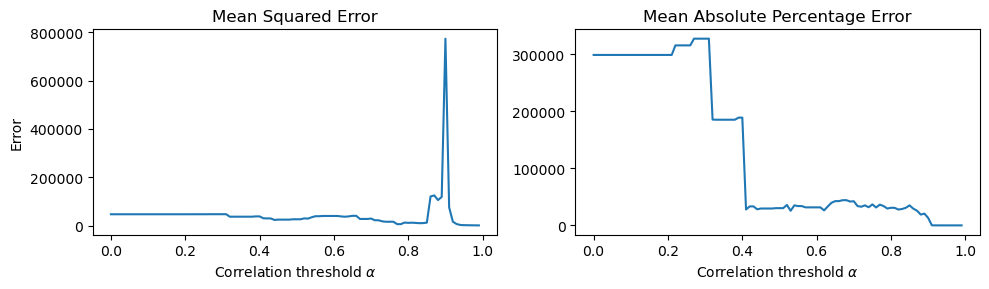

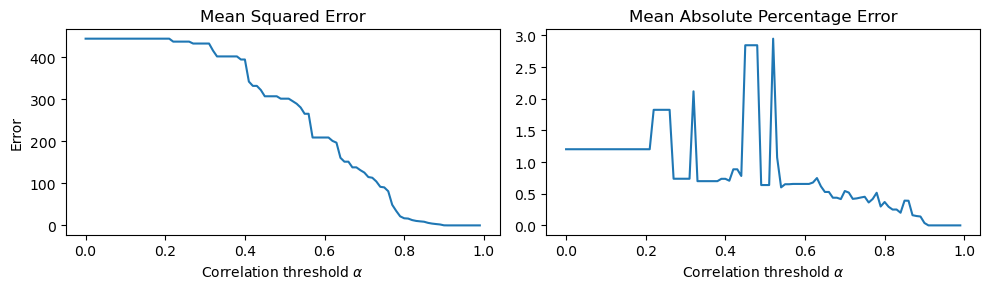

In [13]:
def build_c(representatives, src):
    return torch.stack([data[r]['overall'][src] for r in representatives]).to(CONFIG.device).T

mat_c = build_c(torch.arange(len(data), dtype=int), 'pred')

def get_reconstructed(mat_c, alpha: float):
    _, mat_x, nonempty, representatives = compress_data(
        mat_c, CONFIG.train_period, CONFIG.train_period, alpha)
    
    mat_c_y = build_c(representatives, 'y')
    mat_c_pred = build_c(representatives, 'pred')
    return (
        decompress(mat_c_y, mat_x),
        decompress(mat_c_pred, mat_x)
    ), representatives


_, _, _, representatives = compress_data(mat_c, CONFIG.train_period, CONFIG.train_period, 0.99)
missing = torch.ones(len(data), dtype=bool)
missing[representatives] = False
missing = torch.where(missing)[0]
print(missing)


mse = MeanSquaredError().to(CONFIG.device)
mape = MeanAbsolutePercentageError().to(CONFIG.device)

losses_mse = []
losses_mape = []
alphas = torch.arange(0.0, 1.0, 0.01)
for alpha in alphas:
    (y, pred), rep = get_reconstructed(mat_c, alpha)
    # losses_mse.append((
    #     mse(mat_c[:, missing[0]], y[:, missing[0]]),
    #     mse(mat_c[:, missing[0]], pred[:, missing[0]])
    # ))
    # losses_mape.append((
    #     mape(mat_c[:, missing[0]], y[:, missing[0]]),
    #     mape(mat_c[:, missing[0]], pred[:, missing[0]])
    # ))
    losses_mse.append((
        mse(mat_c, y),
        mse(mat_c, pred)
    ))
    losses_mape.append((
        mape(mat_c, y),
        mape(mat_c, pred)
    ))

losses_mse = torch.tensor(losses_mse)
losses_mape = torch.tensor(losses_mape)

def plot_losses(losses_mse, losses_mape):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].plot(alphas, losses_mse)
    axes[0].set_title('Mean Squared Error')
    axes[0].set_xlabel(r'Correlation threshold $\alpha$')
    axes[0].set_ylabel('Error')
    axes[1].plot(alphas, losses_mape)
    axes[1].set_title('Mean Absolute Percentage Error')
    axes[1].set_xlabel(r'Correlation threshold $\alpha$')
    fig.tight_layout()

for i in range(2):
    plot_losses(losses_mse[:, i], losses_mape[:, i])

In [59]:
mat_q_nz = CONFIG.load('mat_q_nonzero.pt')
mean_ratios = []
for P in torch.arange(0.0, 40000, 10):
    mat_q_trend, mat_q_resid = preprocess_data(
        P, mat_q_nz.abs())
    mean_trend = mat_q_trend.real.abs().mean().item()
    mean_resid = mat_q_resid.real.abs().mean().item()
    ratio = mean_trend / mean_resid
    mean_ratios.append((P, ratio))
mean_ratios = torch.tensor(mean_ratios).T
print(mean_ratios)
plt.plot(mean_ratios[0, 1000:], mean_ratios[1, 1000:])
mean_ratios[:, 7]

tensor([70.0000,  4.8855])

In [ ]:
mat_q = CONFIG.load('mat_q.pt')
mat_c, mat_x, nonempty, representatives = compress_data(mat_q, CONFIG.read_period, CONFIG.train_period, 1.0)
mat_q = mat_q[:, nonempty]
mat_c = build_c(torch.arange(len(data), dtype=int), 'y')
print(mat_c.shape)
mat_q_cropped = mat_q#crop_q_between(mat_q, CONFIG.read_period, CONFIG.train_period)
idx, val = min(
    ((i, torch.max(torch.abs(mat_q_cropped[i:len(mat_c) + i, 0] - mat_c[:, 0])).item()) \
    for i in range(len(mat_q_cropped) - len(mat_c))),
    key=lambda x: x[1]
)
print(val)
start = datetime(2021, 1, 1) + timedelta(minutes=idx * 15)
end = start + timedelta(minutes=len(mat_c) * 15)
print(start)
res_period = (start, end)
crop_q_between(mat_q, CONFIG.read_period, res_period), mat_c

torch.Size([108, 356])
10.0
2021-01-11 00:45:00


(tensor(1819492., device='cuda:0'),
 tensor([[  5.0000,  63.0000,  98.0000,  ...,  26.4961,  63.7029,   1.5768],
         [  7.0000,  53.0000, 110.0000,  ...,  42.3937,  50.7188,   1.5768],
         [  6.0000,  42.0000,  98.0000,  ...,  52.9921,  47.8786,   4.7305],
         ...,
         [  2.0000,  18.0000,  33.0000,  ...,  10.5984,  16.6358,   1.5768],
         [  0.0000,  13.0000,  28.0000,  ...,  13.2480,  10.1438,   3.1537],
         [  0.0000,  13.0000,  16.0000,  ...,   7.9488,   7.3035,   0.0000]],
        device='cuda:0'))

In [ ]:
torch.where(mat_c != mat_c.to(dtype=int))

(tensor([  0,   0,   0,  ..., 107, 107, 107], device='cuda:0'),
 tensor([  4,   5,   6,  ..., 352, 353, 354], device='cuda:0'))

(tensor([    0,     1,     1,  ..., 35038, 35039, 35039], device='cuda:0'),
 tensor([140, 204, 275,  ..., 347, 174, 209], device='cuda:0'))

In [ ]:
def prepare_losses(data):
    for key, value in data.items():
        data[key] = value['160']
    print(data.keys())
    print(data['40'].keys())
    print(data['40']['resid'].keys())

    losses = {'resid': [], 'trend': [], 'overall': []}
    for P, P_data in data.items():
        for key in P_data:
            series = P_data[key]
            losses[key].append(mse(
                torch.tensor(series['y']),
                torch.tensor(series['pred'])
                ).item())
    for key, value in losses.items():
        losses[key] = torch.tensor(value)
    
    return losses

In [ ]:
def plot_losses(losses, log):
    fig, axes = plt.subplots(1, 3, figsize=(10,3))
    fig.suptitle('Mean Squared Error')
    xaxis = np.array([float(key) for key in data.keys()])

    axes[0].set_title('Residual component')
    axes[1].set_title('Trend component')
    axes[2].set_title('Overall')

    for i, key in enumerate(losses):
        axes[i].plot(xaxis, losses[key])
        if log:
            axes[i].set_xscale('log')
        axes[i].set_xlabel('Spectral threshold P')

    axes[0].set_ylabel('MSE')
    fig.tight_layout()

dict_keys(['1.265', '4', '12.65', '40', '126.5', '400', '1265', '4000', '12650', '40000'])
dict_keys(['resid', 'trend', 'overall'])
dict_keys(['y', 'pred'])
dict_keys(['1', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '200'])
dict_keys(['resid', 'trend', 'overall'])
dict_keys(['y', 'pred'])


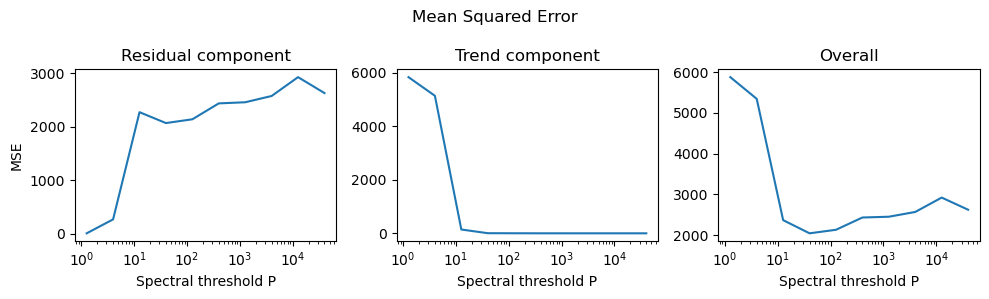

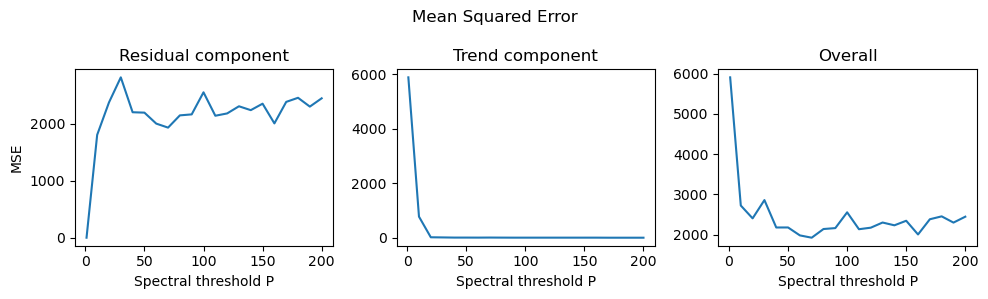

In [ ]:
for file_name in 'results_we_norm_adjust_log.json', 'results_we_norm_adjust_200.json':
    with open('results/' + file_name, 'r') as file:
        data = load(file)
        losses = prepare_losses(data)
        plot_losses(losses, 'log' in file_name)

In [ ]:
with open('results_we_160.json', 'r') as file:
    data = load(file)

NameError: name 'plot_predictions' is not defined

In [ ]:
def plot_predictions(data):
    fig, axes = plt.subplots(1, 3, figsize=(5, 2))
    fig.set_figwidth(15)
    plot_period = CONFIG.train_period
    print(CONFIG.train_period, plot_period)
    captions = ['Residuals', 'Trend', 'Overall']
    for (i, key), caption in zip(enumerate(data), captions):
        print(data[key])
        series = data[key]
        # y = crop_q_between(series['y'][:, None], train_period, plot_period)
        # pred = crop_q_between(series['pred'][:, None], train_period, plot_period)
        # print(y)
        y = torch.tensor(series['y'])#crop_q_between(series['y'], CONFIG.train_period, plot_period)
        pred = torch.tensor(series['pred'])#crop_q_between(series['pred'], CONFIG.train_period, plot_period)
        axes[i].title.set_text(caption)
        axes[i].plot(y, label='Ground truth')
        axes[i].plot(pred, label='Prediction')
        axes[i].plot(pred - y, label='Error')
        axes[i].set_xlabel('Sample')
    axes[0].set_ylabel('Value')
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.tight_layout()

(datetime.datetime(2021, 5, 31, 0, 0), datetime.datetime(2021, 6, 27, 0, 0)) (datetime.datetime(2021, 5, 31, 0, 0), datetime.datetime(2021, 6, 27, 0, 0))
{'y': [-19.088467806577682, -16.18916305154562, -12.876545712351799, -9.488428071141243, -6.4040783904492855, -4.012369889765978, -2.6779061891138554, -2.708585704676807, 30.567632615566254, 62.13772279024124, 4.762827638536692, 15.588866464793682, 7.6038602739572525, -1.4285869896411896, -46.02449682354927, 48.70304027199745, -13.447018221020699, 116.85132485628128, 90.95613569021225, 153.36000937223434, 7.5819085240364075, -14.845211267471313, -1.2252918779850006, 13.401766836643219, 46.28172779083252, 27.39082232117653, 8.83445155620575, 7.843725711107254, 24.244231939315796, 110.26100891828537, 4.12522280216217, -14.994092792272568, 52.96253967285156, 68.51030248403549, 14.314288079738617, 12.615475833415985, 98.3909439444542, -7.48204904794693, -25.85648611187935, 25.747693061828613, -62.16661188006401, -10.60406357049942, 58.113

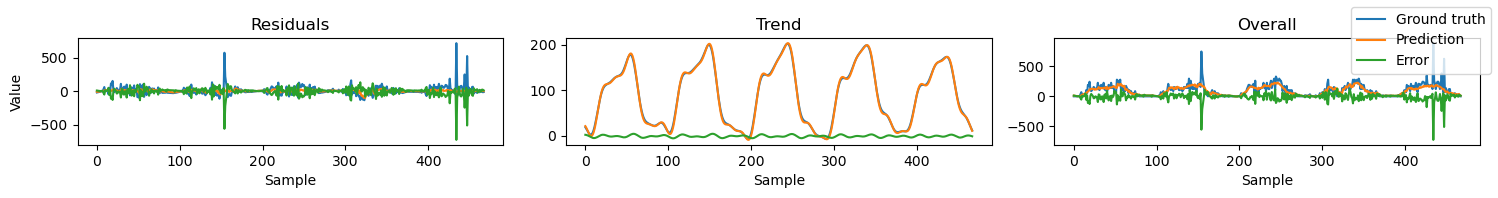

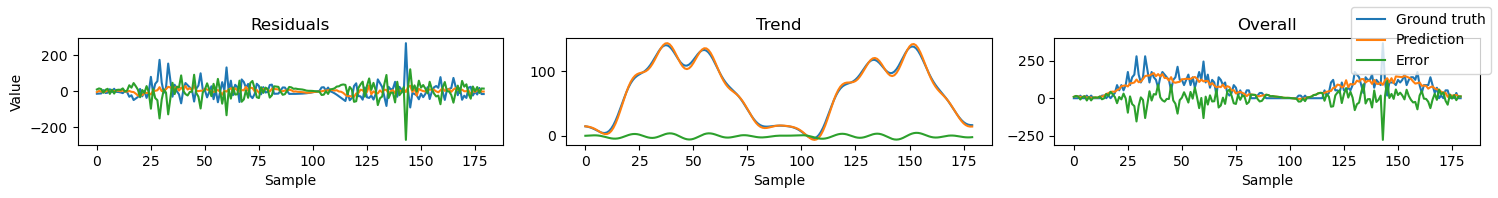

In [ ]:
with open('results_wd_160.json', 'r') as file:
    data = load(file)
plot_predictions(data)
print(len(data['overall']['y']))
with open('results_we_160.json', 'r') as file:
    data = load(file)
plot_predictions(data)
print(len(data['overall']['y']))

tensor([ 0.0104,  0.0088,  0.0070,  0.0052,  0.0035,  0.0022,  0.0015,  0.0015,
         0.0024,  0.0042,  0.0069,  0.0105,  0.0149,  0.0198,  0.0251,  0.0306,
         0.0359,  0.0410,  0.0456,  0.0496,  0.0530,  0.0557,  0.0578,  0.0594,
         0.0605,  0.0612,  0.0618,  0.0624,  0.0630,  0.0636,  0.0644,  0.0653,
         0.0663,  0.0674,  0.0684,  0.0693,  0.0701,  0.0708,  0.0713,  0.0717,
         0.0720,  0.0725,  0.0730,  0.0739,  0.0751,  0.0767,  0.0787,  0.0812,
         0.0839,  0.0868,  0.0898,  0.0926,  0.0949,  0.0966,  0.0974,  0.0973,
         0.0960,  0.0935,  0.0899,  0.0852,  0.0797,  0.0734,  0.0666,  0.0597,
         0.0528,  0.0462,  0.0401,  0.0346,  0.0299,  0.0260,  0.0229,  0.0205,
         0.0187,  0.0173,  0.0163,  0.0156,  0.0150,  0.0145,  0.0139,  0.0134,
         0.0130,  0.0126,  0.0123,  0.0122,  0.0122,  0.0125,  0.0130,  0.0136,
         0.0143,  0.0150,  0.0155,  0.0158,  0.0157,  0.0152,  0.0144,  0.0131,
         0.0114,  0.0096,  0.0077,  0.00

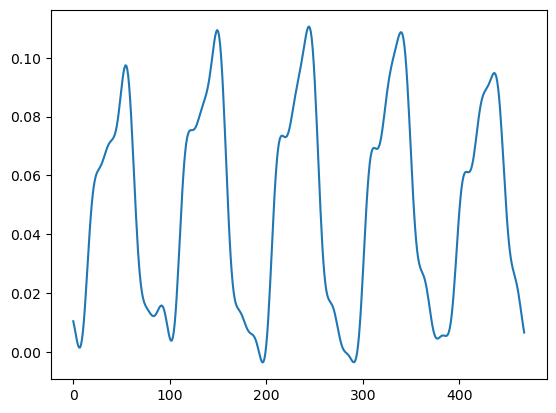

In [ ]:
gt = torch.load('gt.pt')
plt.plot(gt)
gt